In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import re
from datetime import datetime
# import konlpy
from eunjeon import Mecab
from matplotlib import pyplot as plt

c:\users\didix\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\didix\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\didix\anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\didix\anaconda3\envs\py36\lib\site-packages\tensorflow\python\frame

In [2]:
mecab = Mecab()

In [3]:
data = pd.read_csv("data/train.csv", encoding="euc-kr")

In [4]:
data.head()
pd.options.display.max_rows = 1000

In [5]:
print("Data length: {}".format(len(data)))
print("Data shape {}".format(data.shape))
df = data

Data length: 295945
Data shape (295945, 4)


In [6]:
def after_effect(arr):
    words_in_brackets = ['광고']
    ret = []
    idx = 0
    while idx < len(arr):
        if arr[idx] == '(' and idx + 2 < len(arr) and arr[idx + 2] == ')':
            if arr[idx + 1] in '일월화수목금토':
                if len(ret) > 0 and ret[-1] == 'X':
                    ret.pop()
                    ret.append('X일')
                ret.append('(요일)')
                idx += 2
            elif arr[idx + 1] in words_in_brackets:
                ret.append('(' + arr[idx + 1] + ')')
                idx += 2
            else:
                buff = re.sub('[0-9.X]+', 'X', arr[idx])
                buff = re.sub('[-]+', '-', buff)
                buff = re.sub('[X]+', 'X', buff)
                ret.append(buff)
        else:
            buff = re.sub('[0-9.X]+', 'X', arr[idx])
            buff = re.sub('[-]+', '-', buff)
            buff = re.sub('[X]+', 'X', buff)
            ret.append(buff)
        idx += 1
    return ret

In [7]:
def parse_sentence(sentence):
    prev_word, prev_pos = '', ''
    nouns = []
    words = []
    adverbs = []
    etc = []
    buff = ''
    ret = []
    condition = False
    idx, condidx = 0, 0
    
    for word, pos in mecab.pos(sentence):
        # S인 경우 '() 각각 있는 경우 나누어서 여러개의 S로 처리'
        if pos in ('SF') or pos[:1] in ('J'):
            # 은/는/이/가/. 등
            prev_word, prev_pos = '', ''
            continue

        if pos[:1] == 'N' and prev_pos[:1] == 'S':
            # 1억, 1천만원 등
            word = re.sub('[억천만]', '', word)
            if len(word) == 0:
                continue

#         if pos[:1] == 'S':
#             word = re.sub('[(:)]', '', word)
#             word = re.sub('[0-9.X]+', 'X', word)

        # 조건절 판단
        if prev_pos[-3:] == 'ETM' and word in ['분','고객','개인','사업자','이','대상','당신','직원','VIP', '자','분도','전문직','신용자','외국인','본인','임직원','부모','회계사','귀하','투자자','분과']:
            condition = True  
        elif pos[:1] == 'N':
            if word[:2] in ('경우', '필요', '라면', '다면'): # 경우, 필요 단어 등장 시 조건절로 판단
                condition = True
        elif pos[-2:] == 'EC':
            # 여도, 라도, 라면, 면
            if word[-1:] in ('면', '도') or word[-2:] in ('도록'):
                condition = True

        if pos[:1] == 'E':
            buff += word
        #elif pos[:1] == 'N' and prev_pos[:1] == 'N' and len(word) == 1:
        #    buff += word
        elif pos[:1] == 'S' and prev_pos[:1] == 'S' and word[:1] in 'X0123456789%.-': #('%', '.', '-'):
            pos_x = re.search('[0-9X]', buff)
            pos_x = pos_x.span()[0] if pos_x is not None else len(buff)
            if pos_x > 0:
                words.append(buff[:pos_x])
                buff = buff[pos_x:]
            
            # 중간에 %가 있는 경우
            if len(buff) > 0:
                pos_pct = re.search('%', buff)
                pos_pct = (pos_pct.span()[0] + 1) if pos_pct is not None else 0
                if pos_pct > 0:
                    words.append(buff[:pos_pct])
                    buff = buff[pos_pct:]
                
            buff += word

        elif pos[:1] in ('N', 'S') and prev_pos[:1] == 'S' and len(buff) > 0:
            # 숫자 앞에 문자가 있는 경우
            pos_x = re.search('[0-9X]', buff)
            pos_x = pos_x.span()[0] if pos_x is not None else len(buff)
            if pos_x > 0:
                words.append(buff[:pos_x])
                buff = buff[pos_x:]

            # 중간에 %가 있는 경우
            if len(buff) > 0:
                pos_pct = re.search('%', buff)
                pos_pct = (pos_pct.span()[0] + 1) if pos_pct is not None else 0
                if pos_pct > 0:
                    words.append(buff[:pos_pct])
                    buff = buff[pos_pct:]

            if word in ('시', '분', '초', '시간'):
                buff = re.sub('시', '', buff)
                buff += '시'
            elif word in ('년', '월', '일', '개월'):
                buff = re.sub('일', '', buff)
                buff += '일'
            elif word in ('원'):
                buff = re.sub('원', '', buff)
                buff += '원'
                prev_word, prev_pos = word, pos
            elif word in ('배'):
                buff += '%'
                prev_word, prev_pos = word, pos
            elif word in ('kg', 'pt', '형'):
                buff += '단위'
                prev_word, prev_pos = word, 'N' #pos
            elif word in ('건', '종', '대'):
                buff += '개'
                prev_word, prev_pos = word, pos
            else:
                if len(buff) > 0:
                    words.append(buff)
                buff = word
        else:
            if len(buff) > 0:
                # 중간에 %가 있는 경우
                if len(buff) > 0:
                    pos_pct = re.search('%', buff)
                    pos_pct = (pos_pct.span()[0] + 1) if pos_pct is not None else 0
                    if pos_pct > 0:
                        words.append(buff[:pos_pct])
                        buff = buff[pos_pct:]
                if True: #buff != 'X':
                    words.append(buff)
                    # M, N 경우만 저장해보자
                    if prev_pos[:1] in ('N'):  # 'M', 
                        nouns.append(buff)
                    elif prev_pos[:1] in ('M'):
                        adverbs.append(buff)
            buff = word
            prev_word, prev_pos = word, pos

        if pos[-2:] in ('EF'): # and word[0][-1:] in ['요', '다']:
            # words가 꼭 명사를 뜻하는 게 아니고 특색있는 키워드 모두를 포함
            if len(buff) > 0:
                words.append(buff)
            buff = ''
            # 문장의 끝을 구분
            #words.append('(절취선)')
            
            words = after_effect(words)
            ret.append([word, condition, words, nouns, adverbs])
            idx += 1
            if condition: condidx += 1
            nouns = []
            words = []
            adverbs = []
            condition = False
    if len(buff) > 0:
        words.append(buff)
    if len(words) > 0:
        words = after_effect(words)
        ret.append([word, condition, words, nouns, adverbs])
        idx += 1
        if condition: condidx += 1
    etc.append(condidx / idx)
    return ret, etc

In [8]:
smishings = []
normals = []
idx = 0
for idx, item in df.iterrows():
    #print(item.text)
    splited, etc = parse_sentence(item.text)
    etc.append(np.log(len(item.text))/8)  # 문장 전체의 길이
    etc.append(np.log(len(splited))/4)  # 문장의 개수
    splited.append(etc)
    splited.append(item.id)
    #splited = m.parse(item.text).split()
    if item.smishing == 1:
        smishings.append(splited)
    else:
        normals.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1
#     if idx > 20000:
#         break

2020-03-10 18:17:39.568581 0
2020-03-10 18:19:18.794197 100000
2020-03-10 18:21:14.262098 200000


In [9]:
print(f'normals length : {len(normals)}')
print(f'smishings length : {len(smishings)}')

normals length : 277242
smishings length : 18703


In [11]:
print("normals : ",normals[:1])
print("smishing : ",smishings[:1])

normals :  [[['입니다', False, ['X', '행성', '산', 'X', '팀장', '입니다'], ['XXX', '행성'], []], ['세요', False, ['행복', '한', '주말', '되세요'], ['행복', '주말'], []], [0.0, 0.3972567287934932, 0.17328679513998632], 0]]
smishing :  [[['합니다', False, ['(광고)', 'XBaX', '고객', '님', '들', '뒤', 'X', '언제나', 'X', '새로운', '마음가짐', '새롭게', '준비', '합니다'], ['뒤', '마음가짐', '준비'], ['언제나']], ['드립니다', False, ['당', '행', '상품', '자격', '기준', '심사', '기준', '완화', '되어', '상품', '대해', '간단', '하게', '상품', '정보', '전달', '드립니다'], ['당', '상품', '자격', '기준', '심사', '기준', '완화', '상품', '상품', '정보', '전달'], []], ['습니다', True, ['수신', '희망', '하지', '않으실', '경우', '거부', '라는', '답장', '주시면', 'KISA', '수신', '거부', '목록', '등록', '시켜', '두', '번', '다시', '발송', '되지', '않도록', '조치', '취해', '드리겠습니다'], ['수신', '희망', '경우', '거부', '답장', '목록', '등록', '번', '발송', '조치'], ['두', '다시']], ['습니다', True, ['신청', '방법', ':', 'X-X-X', '터치', '하셔서', '문자', '상담', '또는', 'X시', '상담', '이라고', '답장', '보내', '주시거나', '전화', '주시면', '친절', '하고', '안전', '한', '상담', '도움', '드리겠습니다'], ['신청', '방법', '문자', '상담', '답장', '전화', '친절', '안전', '

selected normal-like words count: 191
selected smishing-like words count: 1683


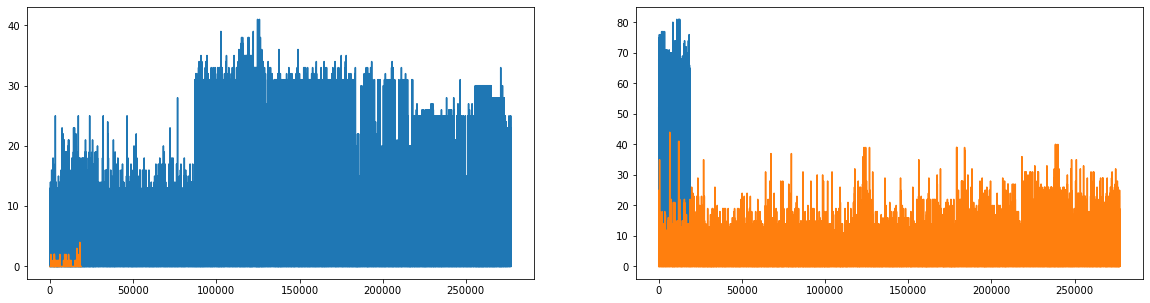

In [12]:
# 스미싱에만 등장하는 noun들 : smish_target_words
NORM_THRESHOLD, SMISH_THRESHOLD = 1000, 2
POS_IDX_IN_ARR = 3
IDX_TO_CUT = -2
norm_dict = {}
for item in [x for normal in normals for row in normal[:IDX_TO_CUT] for x in row[POS_IDX_IN_ARR]]:
    if item in norm_dict:
        norm_dict[item] += 1
    else:
        norm_dict[item] = 1
norm_filter_words = {x:norm_dict.get(x) for x in norm_dict if norm_dict.get(x) > NORM_THRESHOLD}

smish_dict = {}
for item in [x for smishing in smishings for row in smishing[:IDX_TO_CUT] for x in row[POS_IDX_IN_ARR]]:
    if item in smish_dict:
        smish_dict[item] += 1
    else:
        smish_dict[item] = 1
smish_filter_words = {x:smish_dict.get(x) for x in smish_dict if smish_dict.get(x) > SMISH_THRESHOLD}
        
word_only_in_smishings = [word for word in smish_dict if word not in norm_filter_words]
word_only_in_normals = [word for word in norm_dict if word not in smish_filter_words]

norm_target_words = {x:norm_dict.get(x) for x in word_only_in_normals if norm_dict.get(x) > NORM_THRESHOLD}
smish_target_words = {x:smish_dict.get(x) for x in word_only_in_smishings if smish_dict.get(x) > SMISH_THRESHOLD}
print('selected normal-like words count:', len(norm_target_words))
print('selected smishing-like words count:', len(smish_target_words))

smishing_word_cnt, smishing_noword_cnt = [], []
normal_word_cnt, normal_noword_cnt = [], []
for smishing in smishings:
    notarget_word_list = [x for row in smishing[:IDX_TO_CUT] for x in row[POS_IDX_IN_ARR] if x in norm_target_words]
    target_word_list = [x for row in smishing[:IDX_TO_CUT] for x in row[POS_IDX_IN_ARR] if x in smish_target_words]
    smishing.insert(-2, notarget_word_list)
    smishing.insert(-2, target_word_list)
    smishing_noword_cnt.append(len(notarget_word_list))
    smishing_word_cnt.append(len(target_word_list))
for normal in normals:
    notarget_word_list = [x for row in normal[:IDX_TO_CUT] for x in row[POS_IDX_IN_ARR] if x in norm_target_words]
    target_word_list = [x for row in normal[:IDX_TO_CUT] for x in row[POS_IDX_IN_ARR] if x in smish_target_words]
    normal.insert(-2, notarget_word_list)
    normal.insert(-2, target_word_list)
    normal_noword_cnt.append(len(notarget_word_list))
    normal_word_cnt.append(len(target_word_list))

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(normal_noword_cnt)
plt.plot(smishing_noword_cnt)

plt.subplot(1,2,2)
plt.plot(smishing_word_cnt)
plt.plot(normal_word_cnt)

selected normal-like adverbs count: 161
selected smishing-like adverbs count: 74


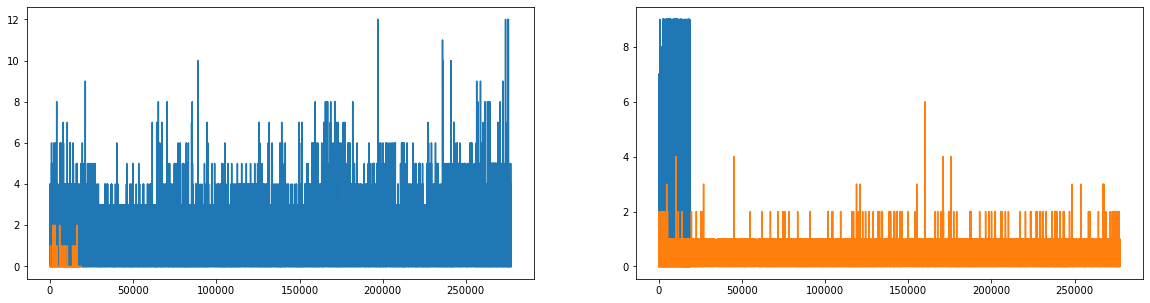

In [13]:
# 스미싱에만 등장하는 adv들 : smish_target_adverbs
NORM_THRESHOLD, SMISH_THRESHOLD = 100, 2
POS_IDX_IN_ARR = 4
IDX_TO_CUT = -4
norm_dict = {}
for item in [x for normal in normals for row in normal[:IDX_TO_CUT] for x in row[POS_IDX_IN_ARR]]:
    if item in norm_dict:
        norm_dict[item] += 1
    else:
        norm_dict[item] = 1
norm_filter_adverbs = {x:norm_dict.get(x) for x in norm_dict if norm_dict.get(x) > NORM_THRESHOLD}

smish_dict = {}
for item in [x for smishing in smishings for row in smishing[:IDX_TO_CUT] for x in row[POS_IDX_IN_ARR]]:
    if item in smish_dict:
        smish_dict[item] += 1
    else:
        smish_dict[item] = 1
smish_filter_adverbs = {x:smish_dict.get(x) for x in smish_dict if smish_dict.get(x) > SMISH_THRESHOLD}
        
adverb_only_in_smishings = [adverb for adverb in smish_dict if adverb not in norm_filter_adverbs]
adverb_only_in_normals = [adverb for adverb in norm_dict if adverb not in smish_filter_adverbs]

norm_target_adverbs = {x:norm_dict.get(x) for x in adverb_only_in_normals if norm_dict.get(x) > NORM_THRESHOLD}
smish_target_adverbs = {x:smish_dict.get(x) for x in adverb_only_in_smishings if smish_dict.get(x) > SMISH_THRESHOLD}
print('selected normal-like adverbs count:', len(norm_target_adverbs))
print('selected smishing-like adverbs count:', len(smish_target_adverbs))

smishing_adverb_cnt, smishing_noadverb_cnt = [], []
normal_adverb_cnt, normal_noadverb_cnt = [], []
for smishing in smishings:
    notarget_adverb_list = [x for row in smishing[:IDX_TO_CUT] for x in row[POS_IDX_IN_ARR] if x in norm_target_adverbs]
    target_adverb_list = [x for row in smishing[:IDX_TO_CUT] for x in row[POS_IDX_IN_ARR] if x in smish_target_adverbs]
    smishing.insert(-2, notarget_adverb_list)
    smishing.insert(-2, target_adverb_list)
    smishing_noadverb_cnt.append(len(notarget_adverb_list))
    smishing_adverb_cnt.append(len(target_adverb_list))
for normal in normals:
    notarget_adverb_list = [x for row in normal[:IDX_TO_CUT] for x in row[POS_IDX_IN_ARR] if x in norm_target_adverbs]
    target_adverb_list = [x for row in normal[:IDX_TO_CUT] for x in row[POS_IDX_IN_ARR] if x in smish_target_adverbs]
    normal.insert(-2, notarget_adverb_list)
    normal.insert(-2, target_adverb_list)
    normal_noadverb_cnt.append(len(notarget_adverb_list))
    normal_adverb_cnt.append(len(target_adverb_list))

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(normal_noadverb_cnt)
plt.plot(smishing_noadverb_cnt)

plt.subplot(1,2,2)
plt.plot(smishing_adverb_cnt)
plt.plot(normal_adverb_cnt)

In [14]:
# rows + notarget + target + noadverb + adverb + etc + idx
[print(x) for x in normals[10]]

['어요', True, ['첫날', '아니지만', '누군가', '행복', '빌어', '주면', '한', '달', '내내', '행복', '하다는', '문자', '받았어요'], ['첫날', '누군가', '행복', '달', '행복', '문자'], ['한', '내내']]
['세요', False, ['X일', '한', '달', '내내', '행복', '가득', '하시길', '바라며', '주말', '잘', '보내세요'], ['달', '행복', '주말'], ['한', '내내', '가득', '잘']]
['올림', False, ['X', '은행', '청계', 'X', 'X', '올림'], ['3'], []]
[]
['누군가']
['내내', '내내']
[]
[0.3333333333333333, 0.5624762087912831, 0.27465307216702745]
12


[None, None, None, None, None, None, None, None, None]

In [15]:
class wordCounter():
    def __init__(self):
        self.word_bank = {}
    
    def add_bucket(self, bucket_name):
        self.word_bank[bucket_name] = {}
        
    def add_list(self, bucket_name, word_list:[]):
        bucket = self.word_bank[bucket_name]
        for keyword in word_list:
            if keyword in bucket:
                bucket[keyword] += 1
            else:
                bucket[keyword] = 1
                
    def get_counts(self, bucket_name):
        return self.word_bank[bucket_name]

In [16]:
wc = wordCounter()
wc.add_bucket('conditioned')
wc.add_bucket('general')
wc.add_bucket('whole')
wc.add_bucket('notargets')
wc.add_bucket('targets')
wc.add_bucket('noadverbs')
wc.add_bucket('adverbs')

LEN_OF_OTHERS = 6

for normal in normals:
    for item in normal[:-LEN_OF_OTHERS]:
        wc.add_list('whole', item[2])
        if item[1] == True:
            wc.add_list('conditioned', item[3])
        else:
            wc.add_list('general', item[3])
    wc.add_list('notargets', normal[-6])
    wc.add_list('targets', normal[-5])
    wc.add_list('noadverbs', normal[-4])
    wc.add_list('adverbs', normal[-3])

for smishing in smishings:
    for item in smishing[:-LEN_OF_OTHERS]:
        wc.add_list('whole', item[2])
        if item[1] == True:
            wc.add_list('conditioned', item[3])
        else:
            wc.add_list('general', item[3])
    wc.add_list('notargets', smishing[-6])
    wc.add_list('targets', smishing[-5])
    wc.add_list('noadverbs', smishing[-4])
    wc.add_list('adverbs', smishing[-3])

In [17]:
conditioned_df = pd.Series(wc.get_counts('conditioned'))
general_df = pd.Series(wc.get_counts('general'))
whole_df = pd.Series(wc.get_counts('whole'))
notargets_df = pd.Series(wc.get_counts('notargets'))
targets_df = pd.Series(wc.get_counts('targets'))
noadverbs_df = pd.Series(wc.get_counts('noadverbs'))
adverbs_df = pd.Series(wc.get_counts('adverbs'))

# 글자가 2개 이상인 것만 모아보자
conditioned_df = conditioned_df[conditioned_df.index.map(len) > 1]  # M 만 포함시켰으므로.. 길이 2이상인것만
general_df = general_df[general_df.index.map(len) > 1]  # M 만 포함시켰으므로.. 길이 2이상인것만
# targets_df 일단 생략

# 3번 이상 출현한 것만 모아보자
#conditioned_df = conditioned_df[conditioned_df.sort_values() > 2]
#general_df = general_df[general_df.sort_values() > 2]

In [18]:
general_dic = general_df[general_df > 1].sort_values(ascending=False)
general_dic = general_dic.reset_index()['index'].to_dict()
general_vocab = {general_dic.get(k):k for k in general_dic}

In [19]:

conditioned_dic = conditioned_df[conditioned_df > 1].sort_values(ascending=False)
conditioned_dic = conditioned_dic.reset_index()['index'].to_dict()
conditioned_vocab = {conditioned_dic.get(k):k for k in conditioned_dic}

In [20]:
whole_dic = whole_df[whole_df > 1].sort_values(ascending=False)
whole_dic = whole_dic.reset_index()['index'].to_dict()
whole_vocab = {whole_dic.get(k):k for k in whole_dic}

In [21]:
notargets_dic = notargets_df[notargets_df > 1].sort_values(ascending=False)
notargets_dic = notargets_dic.reset_index()['index'].to_dict()
notargets_vocab = {notargets_dic.get(k):k for k in notargets_dic}

targets_dic = targets_df[targets_df > 1].sort_values(ascending=False)
targets_dic = targets_dic.reset_index()['index'].to_dict()
targets_vocab = {targets_dic.get(k):k for k in targets_dic}

In [22]:

noadverbs_dic = noadverbs_df[noadverbs_df > 1].sort_values(ascending=False)
noadverbs_dic = noadverbs_dic.reset_index()['index'].to_dict()
noadverbs_vocab = {noadverbs_dic.get(k):k for k in noadverbs_dic}

adverbs_dic = adverbs_df[adverbs_df > 1].sort_values(ascending=False)
adverbs_dic = adverbs_dic.reset_index()['index'].to_dict()
adverbs_vocab = {adverbs_dic.get(k):k for k in adverbs_dic}

In [23]:
# smishing cases; length of vocab when it's out of vocab
tidf_conditioned = []
tidf_general = []
tidf_whole = []
tidf_notargets = []
tidf_targets = []
tidf_noadverbs = []
tidf_adverbs = []
tidf_etc = []
original_idx = []

cond_vocabsize = len(conditioned_vocab)
gen_vocabsize = len(general_vocab)
whole_vocabsize = len(whole_vocab)
notargets_vocabsize = len(notargets_vocab)
targets_vocabsize = len(targets_vocab)
noadverbs_vocabsize = len(noadverbs_vocab)
adverbs_vocabsize = len(adverbs_vocab)

print('size of vocab (conditioned, general, whole):', cond_vocabsize, gen_vocabsize, whole_vocabsize)
print('size of vocab (notargets, targets, noadverbs, adverbs):', notargets_vocabsize, targets_vocabsize, noadverbs_vocabsize, adverbs_vocabsize)

# 문장별 bag of word를 제외한 항목의 수 : notargets, targets, noadverbs, adverbs, etc, idx
LEN_OF_OTHERS = 6
for msg in normals:
    tidf_conditioned.append([conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for row in msg[:-LEN_OF_OTHERS] if row[1] == True for x in row[3]])
    tidf_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-LEN_OF_OTHERS] if row[1] == False for x in row[3]])
    tidf_whole.append([whole_vocab.get(x) if x in whole_vocab else whole_vocabsize for row in msg[:-LEN_OF_OTHERS] for x in row[2]])
    tidf_notargets.append([notargets_vocab.get(x) if x in notargets_vocab else notargets_vocabsize for x in msg[-6]])
    tidf_targets.append([targets_vocab.get(x) if x in targets_vocab else targets_vocabsize for x in msg[-5]])
    tidf_noadverbs.append([noadverbs_vocab.get(x) if x in noadverbs_vocab else noadverbs_vocabsize for x in msg[-4]])
    tidf_adverbs.append([adverbs_vocab.get(x) if x in adverbs_vocab else adverbs_vocabsize for x in msg[-3]])
    tidf_etc.append(msg[-2])
    original_idx.append(msg[-1])
for msg in smishings:
    tidf_conditioned.append([conditioned_vocab.get(x) if x in conditioned_vocab else cond_vocabsize for row in msg[:-LEN_OF_OTHERS] if row[1] == True for x in row[3]])
    tidf_general.append([general_vocab.get(x) if x in general_vocab else gen_vocabsize for row in msg[:-LEN_OF_OTHERS] if row[1] == False for x in row[3]])
    tidf_whole.append([whole_vocab.get(x) if x in whole_vocab else whole_vocabsize for row in msg[:-LEN_OF_OTHERS] for x in row[2]])
    tidf_notargets.append([notargets_vocab.get(x) if x in notargets_vocab else notargets_vocabsize for x in msg[-6]])
    tidf_targets.append([targets_vocab.get(x) if x in targets_vocab else targets_vocabsize for x in msg[-5]])
    tidf_noadverbs.append([noadverbs_vocab.get(x) if x in noadverbs_vocab else noadverbs_vocabsize for x in msg[-4]])
    tidf_adverbs.append([adverbs_vocab.get(x) if x in adverbs_vocab else adverbs_vocabsize for x in msg[-3]])
    tidf_etc.append(msg[-2])
    original_idx.append(msg[-1])

size of vocab (conditioned, general, whole): 8884 16107 37664
size of vocab (notargets, targets, noadverbs, adverbs): 191 1683 161 74


In [24]:
len(tidf_conditioned), len(tidf_general), len(tidf_etc), len(tidf_targets)

(295945, 295945, 295945, 295945)

In [25]:

convec_size = max([len(x) for x in tidf_conditioned])
genvec_size = max([len(x) for x in tidf_general])
whlvec_size = max([len(x) for x in tidf_whole])
notgtvec_size = max([len(x) for x in tidf_notargets])
tgtvec_size = max([len(x) for x in tidf_targets])
noadvvec_size = max([len(x) for x in tidf_noadverbs])
advvec_size = max([len(x) for x in tidf_adverbs])

# 문장 내 인식한 단어의 개수의 최대값 (문장의 길이가 길수록 크겠지..)
print('conditioned vector minimum size:', convec_size)
print('general vector minimum size:', genvec_size)
print('whole vector minimum size:', whlvec_size)
print('notarget vector minimum size:', notgtvec_size)
print('target vector minimum size:', tgtvec_size)
print('noadverb vector minimum size:', noadvvec_size)
print('adverb vector minimum size:', advvec_size)

conditioned vector minimum size: 192
general vector minimum size: 333
whole vector minimum size: 490
notarget vector minimum size: 41
target vector minimum size: 81
noadverb vector minimum size: 12
adverb vector minimum size: 9


In [26]:
# 훈련용, 훈련검증용, 결과검증용 분리
tidf_conditioned = np.array(tidf_conditioned)
tidf_general = np.array(tidf_general)
tidf_whole = np.array(tidf_whole)
tidf_notargets = np.array(tidf_notargets)
tidf_targets = np.array(tidf_targets)
tidf_noadverbs = np.array(tidf_noadverbs)
tidf_adverbs = np.array(tidf_adverbs)
tidf_etc = np.array(tidf_etc)
tidf_label = np.array([1 if x >= len(normals) else 0 for x in range(tidf_conditioned.shape[0])])

In [28]:
from keras.preprocessing.sequence import pad_sequences

class DataGenerator(keras.utils.Sequence):
    def __init__(self, tidf_cond_train, tidf_gen_train, tidf_whole_train, tidf_notargets_train, tidf_targets_train, tidf_noadverbs_train, tidf_adverbs_train, tidf_etc_train, tidf_label_train, normal_size=160, smishing_size=160, convec_size=350, genvec_size=470, whlvec_size=500, notgtvec_size=100, tgtvec_size=100, noadvvec_size=100, advvec_size=100):
        self.convec_size = convec_size  # including 0 paddings
        self.genvec_size = genvec_size  # including 0 paddings
        self.whlvec_size = whlvec_size  # including 0 paddings
        self.notgtvec_size = notgtvec_size  # including 0 paddings
        self.tgtvec_size = tgtvec_size  # including 0 paddings
        self.noadvvec_size = noadvvec_size  # including 0 paddings
        self.advvec_size = advvec_size  # including 0 paddings
        self.tidf_cond_train_normal = pad_sequences(tidf_cond_train[tidf_label_train == 0], maxlen=self.convec_size, padding='pre')
        self.tidf_gen_train_normal = pad_sequences(tidf_gen_train[tidf_label_train == 0], maxlen=self.genvec_size, padding='pre')
        self.tidf_whole_train_normal = pad_sequences(tidf_whole_train[tidf_label_train == 0], maxlen=self.whlvec_size, padding='pre')
        self.tidf_targets_train_normal = pad_sequences(tidf_targets_train[tidf_label_train == 0], maxlen=self.tgtvec_size, padding='pre')
        self.tidf_notargets_train_normal = pad_sequences(tidf_notargets_train[tidf_label_train == 0], maxlen=self.notgtvec_size, padding='pre')
        self.tidf_adverbs_train_normal = pad_sequences(tidf_adverbs_train[tidf_label_train == 0], maxlen=self.advvec_size, padding='pre')
        self.tidf_noadverbs_train_normal = pad_sequences(tidf_noadverbs_train[tidf_label_train == 0], maxlen=self.noadvvec_size, padding='pre')
        self.tidf_etc_train_normal = tidf_etc_train[tidf_label_train == 0]
        self.tidf_cond_train_smishing = pad_sequences(tidf_cond_train[tidf_label_train == 1], maxlen=self.convec_size, padding='pre')
        self.tidf_gen_train_smishing = pad_sequences(tidf_gen_train[tidf_label_train == 1], maxlen=self.genvec_size, padding='pre')
        self.tidf_whole_train_smishing = pad_sequences(tidf_whole_train[tidf_label_train == 1], maxlen=self.whlvec_size, padding='pre')
        self.tidf_notargets_train_smishing = pad_sequences(tidf_notargets_train[tidf_label_train == 1], maxlen=self.notgtvec_size, padding='pre')
        self.tidf_targets_train_smishing = pad_sequences(tidf_targets_train[tidf_label_train == 1], maxlen=self.tgtvec_size, padding='pre')
        self.tidf_noadverbs_train_smishing = pad_sequences(tidf_noadverbs_train[tidf_label_train == 1], maxlen=self.noadvvec_size, padding='pre')
        self.tidf_adverbs_train_smishing = pad_sequences(tidf_adverbs_train[tidf_label_train == 1], maxlen=self.advvec_size, padding='pre')
        self.tidf_etc_train_smishing = tidf_etc_train[tidf_label_train == 1]
        self.sample_size_normal = normal_size
        self.sample_size_smishing = smishing_size
        self.train_size_normal = len(self.tidf_cond_train_normal)
        self.train_size_smishing = len(self.tidf_cond_train_smishing)
#         self.sample_size = normal_size + smishing_size
#         self.num_batch = int(np.ceil(len(self.tidf_cond_train_normal) // self.sample_size / 10))
        self.num_batch_normal = int(np.ceil(self.train_size_normal / self.sample_size_normal))
        self.num_batch_smishing = int(np.ceil(self.train_size_smishing / self.sample_size_smishing))
        self.normal_train_index = np.array(range(self.train_size_normal))
        self.smishing_train_index = np.array(range(self.train_size_smishing))
        print(f"num_batch_normal: {self.num_batch_normal}, num_batch_smishing: {self.num_batch_smishing}")
    
    def __len__(self):
        return max(self.num_batch_normal, self.num_batch_smishing)
    
    def __getitem__(self, index):
        # sequencial sampling
        normal_idx, smishing_idx = index % self.num_batch_normal, index % self.num_batch_smishing
        #print(f"normal_idx: {normal_idx}, smishing_idx: {smishing_idx}")
        normal_sampling = self.normal_train_index // self.sample_size_normal == normal_idx
#         normal_sampling = np.random.choice(len(self.tidf_cond_train_normal), self.normal_sample_size)
        normal_cond_sample = self.tidf_cond_train_normal[normal_sampling]
        normal_gen_sample = self.tidf_gen_train_normal[normal_sampling]
        normal_whole_sample = self.tidf_whole_train_normal[normal_sampling]
        normal_notargets_sample = self.tidf_notargets_train_normal[normal_sampling]
        normal_targets_sample = self.tidf_targets_train_normal[normal_sampling]
        normal_noadverbs_sample = self.tidf_noadverbs_train_normal[normal_sampling]
        normal_adverbs_sample = self.tidf_adverbs_train_normal[normal_sampling]
        normal_etc_sample = self.tidf_etc_train_normal[normal_sampling]
        smishing_sampling = self.smishing_train_index // self.sample_size_smishing == smishing_idx
#         smishing_sampling = np.random.choice(len(self.tidf_cond_train_smishing), self.smishing_sample_size)
        smishing_cond_sample = self.tidf_cond_train_smishing[smishing_sampling]
        smishing_gen_sample = self.tidf_gen_train_smishing[smishing_sampling]
        smishing_whole_sample = self.tidf_whole_train_smishing[smishing_sampling]
        smishing_notargets_sample = self.tidf_notargets_train_smishing[smishing_sampling]
        smishing_targets_sample = self.tidf_targets_train_smishing[smishing_sampling]
        smishing_noadverbs_sample = self.tidf_noadverbs_train_smishing[smishing_sampling]
        smishing_adverbs_sample = self.tidf_adverbs_train_smishing[smishing_sampling]
        smishing_etc_sample = self.tidf_etc_train_smishing[smishing_sampling]
        sample_cond_train = np.concatenate([normal_cond_sample, smishing_cond_sample])
        sample_gen_train = np.concatenate([normal_gen_sample, smishing_gen_sample])
        sample_whole_train = np.concatenate([normal_whole_sample, smishing_whole_sample])
        sample_notargets_train = np.concatenate([normal_notargets_sample, smishing_notargets_sample])
        sample_targets_train = np.concatenate([normal_targets_sample, smishing_targets_sample])
        sample_noadverbs_train = np.concatenate([normal_noadverbs_sample, smishing_noadverbs_sample])
        sample_adverbs_train = np.concatenate([normal_adverbs_sample, smishing_adverbs_sample])
        sample_etc_train = np.concatenate([normal_etc_sample, smishing_etc_sample])
        sample_label_train = [1 if x >= len(normal_cond_sample) else 0 for x in range(len(sample_cond_train))]
        return [sample_cond_train, sample_gen_train, sample_whole_train, sample_notargets_train, sample_targets_train, sample_noadverbs_train, sample_adverbs_train, sample_etc_train], sample_label_train
#        return [sample_gen_train, sample_etc_train], sample_label_train

    def on_epoch_end(self):
        pass

In [29]:
TRAIN_RATIO, VALID_RATIO = 0.6, 0.8
np.random.seed(0)
split = np.random.rand(tidf_conditioned.shape[0])
tidf_cond_train = tidf_conditioned[split < TRAIN_RATIO]
tidf_cond_valid = tidf_conditioned[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_cond_test = tidf_conditioned[split >= VALID_RATIO]

tidf_gen_train = tidf_general[split < TRAIN_RATIO]
tidf_gen_valid = tidf_general[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_gen_test = tidf_general[split >= VALID_RATIO]

tidf_whole_train = tidf_whole[split < TRAIN_RATIO]
tidf_whole_valid = tidf_whole[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_whole_test = tidf_whole[split >= VALID_RATIO]

tidf_notargets_train = tidf_notargets[split < TRAIN_RATIO]
tidf_notargets_valid = tidf_notargets[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_notargets_test = tidf_notargets[split >= VALID_RATIO]

tidf_targets_train = tidf_targets[split < TRAIN_RATIO]
tidf_targets_valid = tidf_targets[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_targets_test = tidf_targets[split >= VALID_RATIO]

tidf_noadverbs_train = tidf_noadverbs[split < TRAIN_RATIO]
tidf_noadverbs_valid = tidf_noadverbs[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_noadverbs_test = tidf_noadverbs[split >= VALID_RATIO]

tidf_adverbs_train = tidf_adverbs[split < TRAIN_RATIO]
tidf_adverbs_valid = tidf_adverbs[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_adverbs_test = tidf_adverbs[split >= VALID_RATIO]

tidf_etc_train = tidf_etc[split < TRAIN_RATIO]
tidf_etc_valid = tidf_etc[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_etc_test = tidf_etc[split >= VALID_RATIO]

tidf_label_train = tidf_label[split < TRAIN_RATIO]
tidf_label_valid = tidf_label[(split >= TRAIN_RATIO) & (split < VALID_RATIO)]
tidf_label_test = tidf_label[split >= VALID_RATIO]

tidf_cond_train.shape, tidf_cond_valid.shape #, tidf_cond_test.shape

((177533,), (59281,))

In [30]:
# noadverb, adverb 추가했더니 오히려 떨어져서.. adverb쪽 embed size를 1로 줄이고, 나머지도 조금씩 줄여서 overfit완화시도
# conditioned vector minimum size: 194
# general vector minimum size: 333
# whole vector minimum size: 493
# notarget vector minimum size: 40
# target vector minimum size: 85
# noadverb vector minimum size: 13
# adverb vector minimum size: 8
    
num_predictive_factors1, num_predictive_factors2, num_predictive_factors3 = 12, 18, 26
num_predictive_factors4, num_predictive_factors5 = 4, 6
num_predictive_factors6, num_predictive_factors7 = 2, 2
n_cond, n_gen, n_whole, n_notargets, n_targets = convec_size, genvec_size, whlvec_size, notgtvec_size, tgtvec_size
n_noadverbs, n_adverbs, n_etc = noadvvec_size, advvec_size, len(tidf_etc_train[0])

cond_input = keras.layers.Input(shape=(n_cond,), name='Cond')
gen_input = keras.layers.Input(shape=(n_gen,), name='General')
whole_input = keras.layers.Input(shape=(n_whole,), name='Whole')
notargets_input = keras.layers.Input(shape=(n_notargets,), name='NoTargets')
targets_input = keras.layers.Input(shape=(n_targets,), name='Targets')
noadverbs_input = keras.layers.Input(shape=(n_noadverbs,), name='NoAdverbs')
adverbs_input = keras.layers.Input(shape=(n_adverbs,), name='Adverbs')
etc_input = keras.layers.Input(shape=(n_etc,), name='Etc')

cond_vec_mlp = keras.layers.Embedding(cond_vocabsize + 1, num_predictive_factors1, )(cond_input)
cond_vec_mlp = keras.layers.Flatten(name='Flattenconds-MLP')(cond_vec_mlp)
cond_vec_mlp = keras.layers.Dropout(0.3)(cond_vec_mlp)

gen_vec_mlp = keras.layers.Embedding(gen_vocabsize + 1, num_predictive_factors2, )(gen_input)
gen_vec_mlp = keras.layers.Flatten(name='Flattengens-MLP')(gen_vec_mlp)
gen_vec_mlp = keras.layers.Dropout(0.3)(gen_vec_mlp)

whole_vec_mlp = keras.layers.Embedding(whole_vocabsize + 1, num_predictive_factors3, )(whole_input)
whole_vec_mlp = keras.layers.Flatten(name='Flattenwhls-MLP')(whole_vec_mlp)
whole_vec_mlp = keras.layers.Dropout(0.3)(whole_vec_mlp)

notargets_vec_mlp = keras.layers.Embedding(notargets_vocabsize + 1, num_predictive_factors4, )(notargets_input)
notargets_vec_mlp = keras.layers.Flatten(name='FlattenNotgts-MLP')(notargets_vec_mlp)
notargets_vec_mlp = keras.layers.Dropout(0.3)(notargets_vec_mlp)

targets_vec_mlp = keras.layers.Embedding(targets_vocabsize + 1, num_predictive_factors5, )(targets_input)
targets_vec_mlp = keras.layers.Flatten(name='Flattentgts-MLP')(targets_vec_mlp)
targets_vec_mlp = keras.layers.Dropout(0.3)(targets_vec_mlp)

noadverbs_vec_mlp = keras.layers.Embedding(noadverbs_vocabsize + 1, num_predictive_factors4, )(noadverbs_input)
noadverbs_vec_mlp = keras.layers.Flatten(name='FlattenNoadvs-MLP')(noadverbs_vec_mlp)
noadverbs_vec_mlp = keras.layers.Dropout(0.3)(noadverbs_vec_mlp)

adverbs_vec_mlp = keras.layers.Embedding(adverbs_vocabsize + 1, num_predictive_factors5, )(adverbs_input)
adverbs_vec_mlp = keras.layers.Flatten(name='Flattenadvs-MLP')(adverbs_vec_mlp)
adverbs_vec_mlp = keras.layers.Dropout(0.3)(adverbs_vec_mlp)

concat_mlp = keras.layers.merge.concatenate([cond_vec_mlp, gen_vec_mlp, whole_vec_mlp, notargets_vec_mlp, targets_vec_mlp, noadverbs_vec_mlp, adverbs_vec_mlp, etc_input])
concat_dropout_mlp = keras.layers.Dropout(0.3)(concat_mlp)

dense = keras.layers.Dense(24, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-1', activation='relu')(concat_dropout_mlp)
dropout_1 = keras.layers.Dropout(0.3, name='Dropout-1')(dense)

dense_2 = keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-2', activation='relu')(dropout_1)
dropout_2 = keras.layers.Dropout(0.3, name='Dropout-2')(dense_2)

# dense_3 = keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.001), name='FullyConnected-3', activation='relu')(dropout_2)
# dropout_3 = keras.layers.Dropout(0.3, name='Dropout-3')(dense_3)

dense_4 = keras.layers.Dense(16, kernel_regularizer=keras.regularizers.l2(0.0001), name='FullyConnected-4', activation='relu')(dropout_2)
pred_mlp = keras.layers.Dense(1, activation='sigmoid', name='Activation')(dense_4)

model = keras.Model(inputs=[cond_input, gen_input, whole_input, notargets_input, targets_input, noadverbs_input, adverbs_input, etc_input ], output=pred_mlp)  #  etc_input
model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])
#model.compile(optimizer=keras.optimizers.Adamax(lr=1e-3), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])

c:\users\didix\anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("Ac...)`


In [31]:
train_gen = DataGenerator(tidf_cond_train, tidf_gen_train, tidf_whole_train, tidf_notargets_train, tidf_targets_train, tidf_noadverbs_train, tidf_adverbs_train, tidf_etc_train, tidf_label_train, 160, 160, convec_size, genvec_size, whlvec_size, notgtvec_size, tgtvec_size, noadvvec_size, advvec_size)
valid_gen = DataGenerator(tidf_cond_valid, tidf_gen_valid, tidf_whole_valid, tidf_notargets_valid, tidf_targets_valid, tidf_noadverbs_valid, tidf_adverbs_valid, tidf_etc_valid, tidf_label_valid, 1000, 1000, convec_size, genvec_size, whlvec_size, notgtvec_size, tgtvec_size, noadvvec_size, advvec_size)

# 총 20번 train?
history = model.fit_generator(generator=train_gen,
                             epochs = 15,
#                              use_multiprocessing=True,
#                               workers=3,
                             validation_data=valid_gen,
                             verbose=1)

num_batch_normal: 1039, num_batch_smishing: 71
num_batch_normal: 56, num_batch_smishing: 4
Epoch 1/15
1039/1039 [==============================] - 374s 360ms/step - loss: 0.1738 - binary_crossentropy: 0.1250 - acc: 0.9591 - val_loss: 0.0452 - val_binary_crossentropy: 0.0094 - val_acc: 0.9975
Epoch 2/15
1039/1039 [==============================] - 369s 355ms/step - loss: 0.0461 - binary_crossentropy: 0.0174 - acc: 0.9974 - val_loss: 0.0305 - val_binary_crossentropy: 0.0067 - val_acc: 0.9985
Epoch 3/15
1039/1039 [==============================] - 368s 354ms/step - loss: 0.0319 - binary_crossentropy: 0.0105 - acc: 0.9986 - val_loss: 0.0260 - val_binary_crossentropy: 0.0069 - val_acc: 0.9985
Epoch 4/15
1039/1039 [==============================] - 365s 351ms/step - loss: 0.0250 - binary_crossentropy: 0.0076 - acc: 0.9991 - val_loss: 0.0217 - val_binary_crossentropy: 0.0061 - val_acc: 0.9989
Epoch 5/15
1039/1039 [==============================] - 361s 347ms/step - loss: 0.0196 - binary_cross

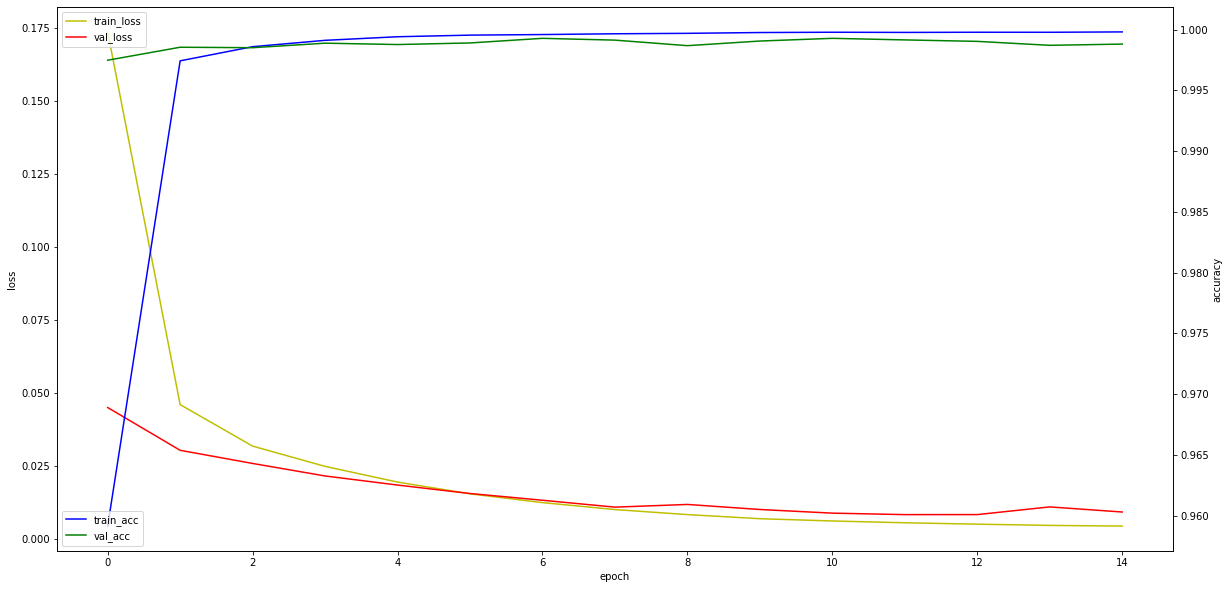

In [32]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train_loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history.history['acc'], 'b', label='train_acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

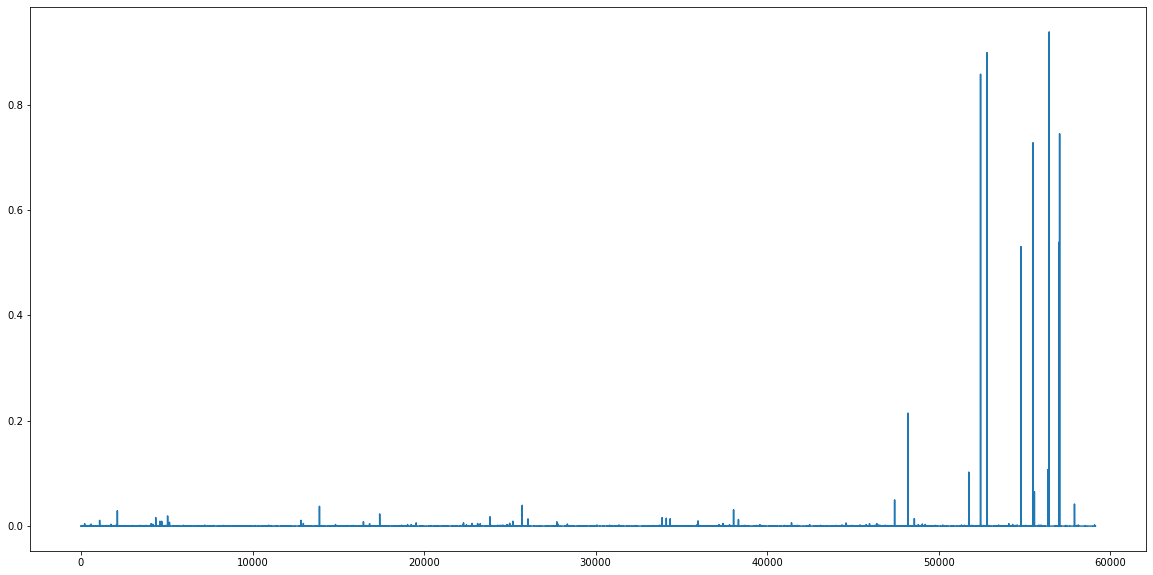

In [34]:
# layer 3개로 늘리고 15번 train
data_gen_test = pad_sequences(tidf_gen_test, maxlen=genvec_size, padding='pre')
data_cond_test = pad_sequences(tidf_cond_test, maxlen=convec_size, padding='pre')
data_whole_test = pad_sequences(tidf_whole_test, maxlen=whlvec_size, padding='pre')
data_notargets_test = pad_sequences(tidf_notargets_test, maxlen=notgtvec_size, padding='pre')
data_targets_test = pad_sequences(tidf_targets_test, maxlen=tgtvec_size, padding='pre')
data_noadverbs_test = pad_sequences(tidf_noadverbs_test, maxlen=noadvvec_size, padding='pre')
data_adverbs_test = pad_sequences(tidf_adverbs_test, maxlen=advvec_size, padding='pre')
data_etc_test = tidf_etc_test

pred_test = model.predict(x=[data_cond_test, data_gen_test, data_whole_test, data_notargets_test, data_targets_test, data_noadverbs_test, data_adverbs_test, data_etc_test], batch_size=160)
gap = np.abs(tidf_label_test - pred_test.reshape([-1,]))

plt.figure(figsize=(20,10))
plt.plot(gap)

In [35]:
df[df['id'].isin(np.array(original_idx)[split >= 0.8][gap > 0.5])].text.map(print)

(광고) 정관장에서 미리 설 준비하시고 특별한 혜택 받으세요!! 예약기간 : 13(화)  19(월) 행사내용 :- 밝을윤세트 은혜은세트 원앙세트 3종 구매 예약시 5% 포인트 추가 적립- 예약방법은 매장으로 문의하여 주세요. 20만원 XXX입 시 1만원 할인- 기간:11128까지적용카드: 현대이마트카드.삼성카드.XXX국민카드.현대카드.XXX카드 결재 시 적용됨. 예약문의 : 정관장 서울 이마트가양점 전화:XX-XXX-XXX 무료수신거부 : XXX-XXX-XXX(광고)정관장 사전예XXX
노사발전재단 경기중장년일XXX망센터 9월 단기취업특강 안내안녕하세요. 고용노동부 산하 중장년 재취업전직을 지원하는 공XXX입니다.  9월 단기취업특강 안내드립니다. 선착순으로 30명 신청을 받고 있습니다. 아래의 일정과 장소 꼭! 확인하시고 연락주세요.  일정- 9월 21일(목) 오후2시오후4시 행복한 노후를 위한 여정- 9월 28일(목) 오후2시오후4시 역경을 이겨내는 힘 감사하기 장소: 노사발전재단 경기중장년일XXX망센터 강의실(수원시 권선구 권광로149 안동빌딩 3층  대중교통: 지하철 분당선 수원시청역 3번출구 앞 1층 아웃백스테이크하우스 XXX 있음) 선착순 30명 모집. 참여 희망시 XXX-XXX-XXX(김나형 컨설턴트) 로 전화주세요.  교육참가확인증 발급노사발전재단 경기중장년일XXX
(광고)트레이더스 서면점 명절행사 및 가XXX 안내명절 선물세트도 트레이더스 서면점이 확실히 저렴 합니다.혜택1:이마트포인트카드 소지 고객설날 선물세트 최대 30%할인행사기간 :1229(금)  215(목) 까지혜택2:선물세트 행사카드 구매 금액대별 최대 100만원 상품권 증정 125(목)131(수) 구매 시-카드종류:삼성국민XXX현대비씨XXX우리하나롯데XXXXXX이마트카드-3050만원이상 구매시:상품권 1만5천원2만5천원 증정-1001000만원 구매시 100만원당 상품권 5만원 증정1000만원 이상 구매시 상품권 100만원 증정트레이더스 서면점 삼성엘지대유위니아 브랜드 대전행사기간: 2

938       None
149795    None
195865    None
196896    None
278052    None
280138    None
291849    None
Name: text, dtype: object

auc : 0.9999999162659995


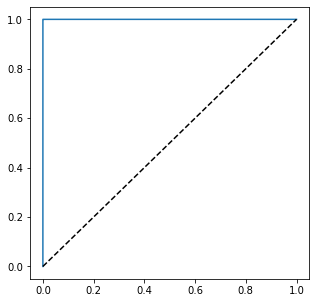

In [37]:
# auc
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import auc
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(tidf_label_test, pred_test)
print('auc :', auc(fpr,tpr))

plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,'-')
plt.plot([0,1],[0,1], 'k--')
plt.show()

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Cond (InputLayer)               (None, 192)          0                                            
__________________________________________________________________________________________________
General (InputLayer)            (None, 333)          0                                            
__________________________________________________________________________________________________
Whole (InputLayer)              (None, 490)          0                                            
__________________________________________________________________________________________________
NoTargets (InputLayer)          (None, 41)           0                                            
__________________________________________________________________________________________________
Targets (I

In [49]:
model.save_weights("model/saved_model_weight")

In [50]:
model.save("model/saved_model")

In [57]:
model.save("model/final_model.h5")